In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# Notes on the paper

## Introduction

- Results on OT:
    - Linear programming: $\tilde{\mathcal{O}}(n^3), \tilde{\mathcal{O}}(n^{5/2})$
    - Entropic regularization: 
        - $\tilde{\mathcal{O}}(n^2/\varepsilon^3), \tilde{\mathcal{O}}(n^2/\varepsilon^2), \tilde{\mathcal{O}}(n^{7/3}/\varepsilon)$
        - $\tilde{\mathcal{O}}(n^{2.5}/\varepsilon), \tilde{\mathcal{O}}(n^2/\varepsilon)$: hard to implement.

## Contribution

- Complexity for Sinkhorn for entropic-regulazized UOT is
$$
\mathcal{O} \Big( \frac{n^2}{\varepsilon} \log(n) [\log(\| C \|_\infty ) + \log(\log(n)) + \log (\frac{1}{\varepsilon})] \Big)
$$

# Implementation

In [0]:
import numpy as np
from numpy.linalg import norm
from copy import copy
import cvxpy as cp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

np.random.seed(999)

In [0]:
smallest_float = np.nextafter(np.float32(0), np.float32(1))
float_type = np.longdouble

def max_norm(x):
    return np.amax(np.abs(x))

def compute_entropy(P):
    logP = np.log(P + 1e-20)
    return -1 * np.sum(logP * P - P)


def compute_KL(P, Q):
    log_ratio = np.log(P) - np.log(Q)
    return np.sum(P * log_ratio - P + Q)


def dot(x, y):
    return np.sum(x * y)


def compute_B(C, u, v, eta):
    return np.exp((u + v.T - C) / eta)


def compute_f(C, X, a, b, tau1, tau2):
    Xa = X.sum(axis=1).reshape(-1, 1)
    Xb = X.sum(axis=0).reshape(-1, 1)

    return dot(C, X) + tau1 * compute_KL(Xa, a) + tau2 * compute_KL(Xb, b)


def compute_g_primal(C, u, v, a, b, eta, tau1, tau2):
    B = compute_B(C, u, v, eta)

    Ba = B.sum(axis=1).reshape(-1, 1)
    Bb = B.sum(axis=0).reshape(-1, 1)

    return dot(C, B) + tau1 * compute_KL(Ba, a) + tau2 * compute_KL(Bb, b) - eta * compute_entropy(B)


def compute_g_dual(C, u, v, a, b, eta, tau1, tau2):
    B = compute_B(C, u, v, eta)
    f = eta * np.sum(B) + tau1 * dot(np.exp(- u / tau1), a) + tau2 * dot(np.exp(- v / tau2), b)

    return f


def solve_g_dual_cp(C, a, b, eta, tau):
    dim_a = a.shape[0]
    dim_b = b.shape[0]

    u = cp.Variable(shape=a.shape)
    v = cp.Variable(shape=b.shape)

    u_stack = cp.vstack([u.T for _ in range(dim_b)])
    v_stack = cp.hstack([v for _ in range(dim_a)])

    obj = eta * cp.sum(cp.exp((u_stack + v_stack - C) / eta))
    obj += tau * cp.sum(cp.multiply(cp.exp(- u / tau), a))
    obj += tau * cp.sum(cp.multiply(cp.exp(- v / tau), b))

    prob = cp.Problem(cp.Minimize(obj))
    # prob.solve(solver=cp.SCS, eps=smallest_float)
    prob.solve()

    return prob.value, u.value, v.value


def solve_f_cp(C, a, b, tau1=1.0, tau2=1.0):
    """
    Convex programming solver for standard Unbalanced Optimal Transport.

    :param C:
    :param a:
    :param b:
    :param tau1:
    :param tau2:
    :return:
    """

    X = cp.Variable((a.shape[0], b.shape[0]), nonneg=True)

    row_sums = cp.sum(X, axis=1)
    col_sums = cp.sum(X, axis=0)

    obj = cp.sum(cp.multiply(X, C))

    obj -= tau1 * cp.sum(cp.entr(row_sums))
    obj -= tau2 * cp.sum(cp.entr(col_sums))

    obj -= tau1 * cp.sum(cp.multiply(row_sums, cp.log(a.reshape(-1, ))))
    obj -= tau2 * cp.sum(cp.multiply(col_sums, cp.log(b.reshape(-1, ))))

    obj -= (tau1 + tau2) * cp.sum(X)
    obj += tau1 * cp.sum(a.reshape(-1, )) + tau2 * cp.sum(b.reshape(-1, ))

    prob = cp.Problem(cp.Minimize(obj))
    # prob.solve(solver=cp.SCS, max_iters=10000, eps=1e-6)
    prob.solve()

    return prob.value, X.value
    

def sinkhorn_uot(C, a, b, eta=1.0, tau1=1.0, tau2=1.0, k=100, compute_optimal=True):
    """
    Sinkhorn algorithm for entropic-regularized Unbalanced Optimal Transport.

    :param C:
    :param a:
    :param b:
    :param eta:
    :param tau1:
    :param tau2:
    :param k:
    :param epsilon:
    :return:
    """

    output = {
        "u": list(),
        "v": list(),
        "f": list(),
        "g_dual": list()
    }

    # Compute optimal value and X for unregularized UOT
    if compute_optimal:
        f_optimal, X_optimal = solve_f_cp(C, a, b, tau1=tau1, tau2=tau2)
        output["f_optimal"] = f_optimal
        output["X_optimal"] = X_optimal

    # Initialization
    u = np.zeros_like(a).astype(float_type)
    v = np.zeros_like(b).astype(float_type)

    output["u"].append(copy(u))
    output["v"].append(copy(v))

    # # Compute initial value of f
    # B = compute_B(C, u, v, eta)
    # f = compute_f_primal(C=C, X=B, a=a, b=b, tau1=tau1, tau2=tau2)
    # output["f"].append(f)

    for i in range(k):
        u_old = copy(u)
        v_old = copy(v)
        B = compute_B(C, u, v, eta)

        f = compute_f(C=C, X=B, a=a, b=b, tau1=tau1, tau2=tau2)

        output["f"].append(f)

        # Sinkhorn update
        if i % 2 == 0:
            Ba = B.sum(axis=1).reshape(-1, 1)
            u = (u / eta + np.log(a) - np.log(Ba)) * (tau1 * eta / (eta + tau1))
        else:
            Bb = B.sum(axis=0).reshape(-1, 1)
            v = (v / eta + np.log(b) - np.log(Bb)) * (tau2 * eta / (eta + tau2))

        g_dual = compute_g_dual(C=C, u=u, v=v, a=a, b=b, eta=eta, tau1=tau1, tau2=tau2)

        output["u"].append(copy(u))
        output["v"].append(copy(v))
        output["g_dual"].append(g_dual)

        # err = norm(u - u_old, ord=1) + norm(v - v_old, ord=1)

        # if err < 1e-10:
        #     break
        #
        # if np.abs(f - output["f_optimal"]) < epsilon:
        #     break

    return output


def find_k_sinkhorn(C, a, b, epsilon, f_optimal, eta=1.0, tau1=1.0, tau2=1.0, momentum=100, max_trial=100000):
    # Initialization
    u = np.zeros_like(a)
    v = np.zeros_like(b)

    i = 0
    count = 0
    trial = 0
    start_trial = False

    while True:
        B = compute_B(C, u, v, eta)

        f_primal = compute_f(C=C, X=B, a=a, b=b, tau1=tau1, tau2=tau2)

        # Sinkhorn update
        if i % 2 == 0:
            Ba = B.sum(axis=1).reshape(-1, 1)
            u = (u / eta + np.log(a) - np.log(Ba)) * (tau1 * eta / (eta + tau1))
        else:
            Bb = B.sum(axis=0).reshape(-1, 1)
            v = (v / eta + np.log(b) - np.log(Bb)) * (tau2 * eta / (eta + tau2))

        if np.abs(f_primal - f_optimal) < epsilon:
            # print(f"{i} ------ {np.abs(f_primal - f_optimal)}")
            if count == 0:
                true_flag = i

            counting_flag = i
            count += 1
            start_trial = True

            if count > momentum:
                return true_flag

            # if start_trial:
            #     print("X.")
        else:
            if start_trial:
                counting_flag = -np.inf
                count = 0
                trial += 1

        if trial > max_trial:
            break

        i += 1

    return counting_flag


# Experiment (Checking theorems and lemmas)

## Hyperparameters

In [0]:
range_a = 10
range_b = 10
range_C = 100
dim_a = 100
dim_b = 100
eta = 0.05
tau1 = 1.0
tau2 = 1.0
k = 500

C = np.random.uniform(low=1, high=range_C, size=(dim_a, dim_b)).astype("float128")
C = (C + C.T) / 2
a = np.random.uniform(low=0.1, high=range_a, size=(dim_a, 1)).astype("float128")
b = np.random.uniform(low=0.1, high=range_b, size=(dim_b, 1)).astype("float128")

n = dim_a
tau = tau1

alpha = np.sum(a)
beta = np.sum(b)

exp_name = f"[n={dim_a}]_[tau={'{0:.1f}'.format(np.mean(tau1))}]_[rC={range_C}]_[ra={range_a}]_[rb={range_b}]_[eta={'{0:.2f}'.format(np.mean(eta))}]"

## Solving UOT

In [0]:
g_dual_optimal, u_optimal, v_optimal = solve_g_dual_cp(C=C, a=a, b=b, eta=eta, tau=tau)
output = sinkhorn_uot(C=C, a=a, b=b, eta=eta, tau1=tau1, tau2=tau2, k=k)

## Checking convergence of Sinkhorn algorithm

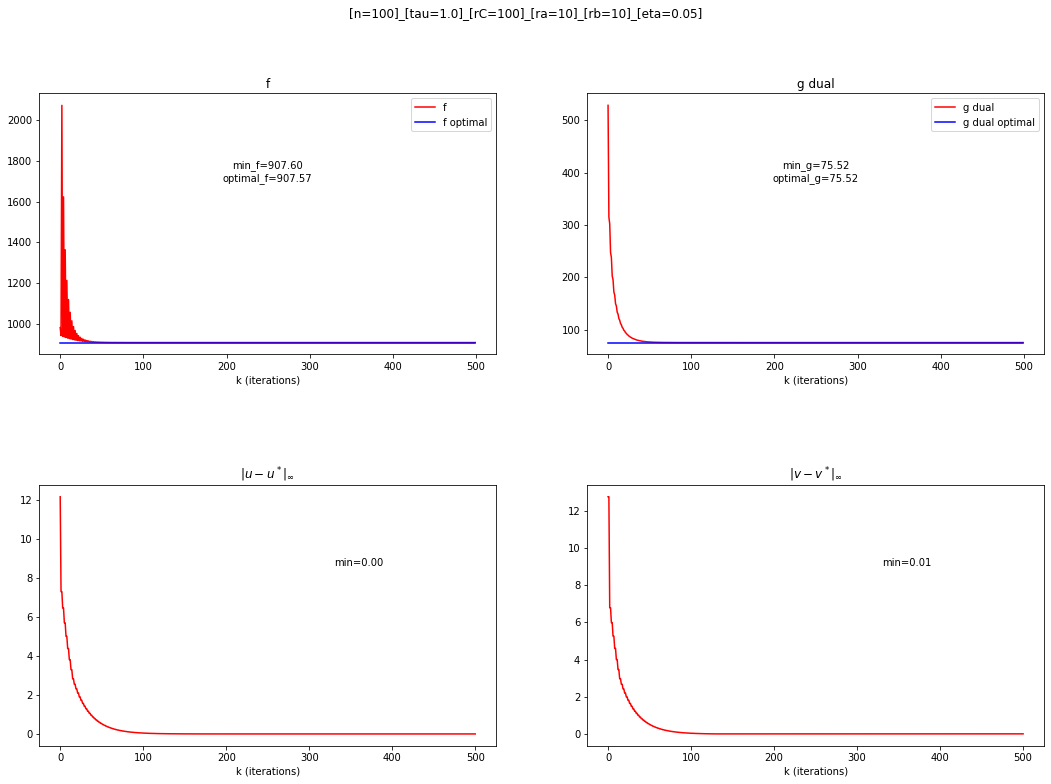

In [0]:
delta_u = [max_norm(u - u_optimal) for u in output["u"]]
delta_v = [max_norm(v - v_optimal) for v in output["v"]]

"""
PLOTTING
"""
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.5)

fig.suptitle(exp_name)

axs[0, 0].plot(list(range(k)), output["f"], "r", label="f")
axs[0, 0].plot([0, k - 1], [output["f_optimal"], output["f_optimal"]], "b", label="f optimal")
axs[0, 0].set_xlabel("k (iterations)")
axs[0, 0].set_title("f")
axs[0, 0].legend()
axs[0, 0].text(x=0.5, y=0.7, s=f"min_f={'{0:.2f}'.format(min(output['f']))}\noptimal_f={'{0:.2f}'.format(output['f_optimal'])}", horizontalalignment='center', verticalalignment='center', transform=axs[0, 0].transAxes)

b1 = 500
b2 = 750
axs[0, 1].plot(list(range(k)), output["g_dual"], "r", label="g dual")
axs[0, 1].plot([0, k - 1], [g_dual_optimal, g_dual_optimal], "b", label="g dual optimal")
axs[0, 1].set_xlabel("k (iterations)")
axs[0, 1].set_title("g dual")
axs[0, 1].legend()
axs[0, 1].text(x=0.5, y=0.7, s=f"min_g={'{0:.2f}'.format(min(output['g_dual']))}\noptimal_g={'{0:.2f}'.format(g_dual_optimal)}", horizontalalignment='center', verticalalignment='center', transform=axs[0, 1].transAxes)

axs[1, 0].plot(list(range(k + 1)), delta_u, "r", label="f optimal")
axs[1, 0].set_xlabel("k (iterations)")
axs[1, 0].set_title(r"$\| u - u^* \|_\infty$")
axs[1, 0].text(x=0.7, y=0.7, s=f"min={'{0:.2f}'.format(delta_u[-1])}", horizontalalignment='center', verticalalignment='center', transform=axs[1, 0].transAxes)

axs[1, 1].plot(list(range(k + 1)), delta_v, "r", label="f optimal")
axs[1, 1].set_xlabel("k (iterations)")
axs[1, 1].set_title(r"$\| v - v^* \|_\infty$")
axs[1, 1].text(x=0.7, y=0.7, s=f"min={'{0:.2f}'.format(delta_v[-1])}", horizontalalignment='center', verticalalignment='center', transform=axs[1, 1].transAxes)

plt.show()

In [0]:
B_star = compute_B(C=C, u=u_optimal, v=v_optimal, eta=eta)
a_star = np.sum(B_star, axis=1, keepdims=True)
b_star = np.sum(B_star, axis=0, keepdims=True).T

R = max(max_norm(np.log(a)), max_norm(np.log(b))) + max(np.log(n), 1 / eta * max_norm(C) - np.log(n))

## Lemma 1

$$
\frac{u^*}{\tau} = \log(a) - \log(a^*) \\
\frac{v^*}{\tau} = \log(b) - \log(b^*)
$$



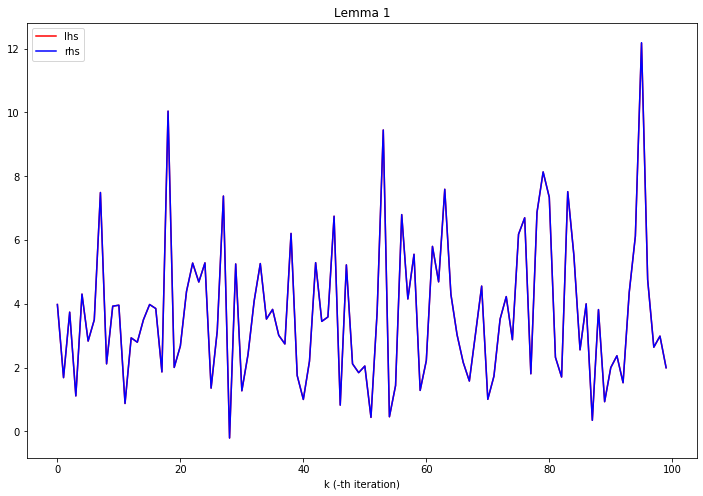

In [0]:
lhs = list(u_optimal / tau)
rhs = list(np.log(a) - np.log(a_star))

plt.figure(figsize=(12, 8))
plt.plot(list(range(n)), lhs, "r", label="lhs")
plt.plot(list(range(n)), rhs, "b", label="rhs")
plt.xlabel("k (-th iteration)")
plt.title("Lemma 1")
plt.legend()

plt.show()

## Lemma 2

$$
\Big| \log\left( \frac{a_i^*}{a_i^k} \right) -  \frac{u_i^* - u_i^k}{\eta}\Big| \leq  \max_{1 \leq j \leq n} \frac{|v^*_j - v^{k}_j|}{\eta}
$$

$$
\Big| \log\left( \frac{b_j^*}{b_j^k} \right) -  \frac{v_j^* - v_j^k}{\eta}\Big| \leq  \max_{1 \leq i \leq n} \frac{|u^*_i - u^{k}_i|}{\eta}
$$

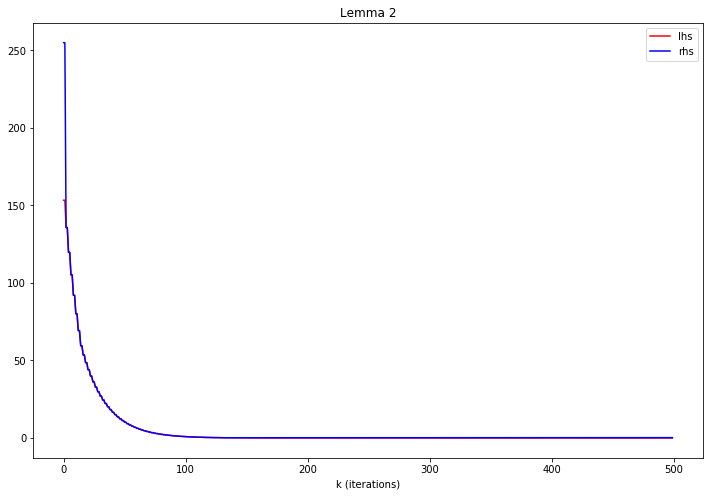

In [0]:
B_k_list = [compute_B(C=C, u=output["u"][i], v=output["v"][i], eta=eta) for i in range(k)]
a_k_list = [np.sum(B_k_list[i], axis=1, keepdims=True) for i in range(k)]
b_k_list = [np.sum(B_k_list[i], axis=0, keepdims=True).T for i in range(k)]
lhs = [max_norm(np.log(a_star / a_k_list[i]) - (u_optimal - output["u"][i]) / eta) for i in range(k)]
rhs = [max_norm((v_optimal - output["v"][i]) / eta) for i in range(k)]

plt.figure(figsize=(12, 8))

plt.plot(list(range(k)), lhs, "r", label="lhs")
plt.plot(list(range(k)), rhs, "b", label="rhs")
plt.xlabel("k (iterations)")
plt.title("Lemma 2")
plt.legend()

plt.show()

## Lemma 3

$$
\max \{ \|u^*\|_{\infty},\|v^*\|_\infty \} \le \tau R
$$

## Theorem 1

$$
\max \{ \| u^{k} -  u^*\|_\infty, \| v^{k} -  v^*\|_\infty \} \le \Big( \frac{\tau}{\tau + \eta} \Big)^k \times \tau \times R
$$

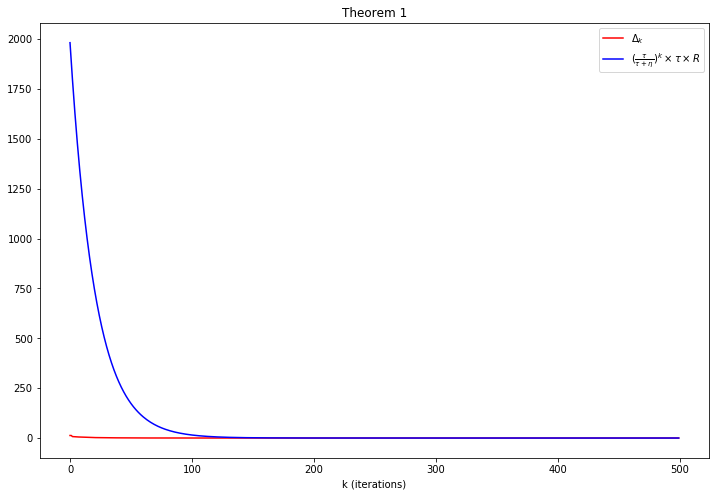

In [0]:
delta_k_list = [max(delta_u[i], delta_v[i]) for i in range(k)]
bound_list = [np.power(tau / (tau + eta), i) * tau * R for i in range(k)]

plt.figure(figsize=(12, 8))
plt.plot(list(range(k)), delta_k_list, "r", label=r"$\Delta_{k}$")
plt.plot(list(range(k)), bound_list, "b", label=r"$(\frac{\tau}{\tau + \eta})^k \times \tau \times R$")
plt.xlabel("k (iterations)")
plt.title("Theorem 1")
plt.legend()

plt.show()

As the plot suggests, the inequality is quite loose when $k$ is small.

## Lemma 4

$$
g(X^*) + (2 \tau + \eta) x^* = \tau (\alpha + \beta) \\
f(\hat{X}) + 2 \tau \hat{x} = \tau (\alpha + \beta)
$$

In [0]:
g_X_star = compute_g_primal(C=C, u=u_optimal, v=v_optimal, a=a, b=b, eta=eta, tau1=tau, tau2=tau)
X_star = compute_B(C=C, u=u_optimal, v=v_optimal, eta=eta)
x_star = np.sum(X_star)

print("LHS 1: ", g_X_star + (2 * tau + eta) * x_star)
print("RHS 1: ", tau * (alpha + beta))

LHS 1:  980.774417631171918
RHS 1:  980.7746274968506354


In [0]:
f_X_hat = output["f_optimal"]
X_hat = output["X_optimal"]
x_hat = np.sum(X_hat)

print("LHS 2: ", f_X_hat + 2 * tau * x_hat)
print("RHS 2: ", tau * (alpha + beta))

LHS 2:  980.7746277081164
RHS 2:  980.7746274968506354


# Experiment (Synthetic data)

## Varyinng $\varepsilon$

### Computation of quantities

$\newcommand{\mnorm}[1]{\|{#1}\|_{\scriptscriptstyle \infty}}$

$$
\begin{align}
R &= \max \left\{ \mnorm{\log(a)}, \mnorm{\log(a)} \right\} + \max \left\{ \log(n), \frac{1}{\eta} \mnorm{\log(C)} - \log(n) \right\} \\
S &=  \frac{1}{2} (\alpha + \beta) + \frac{1}{2} + \frac{1}{4 \log(n)} \\
T &= \frac{1}{2} (\alpha + \beta) \left[ \log\left( \frac{\alpha + \beta}{2} \right) + 2 \log(n) - 1 \right] + \log(n) + \frac{5}{2} \\
U &= \max \left\{ S + T, 2 \varepsilon, \frac{4 \varepsilon \log(n)}{\tau}, \frac{4 \varepsilon (\alpha + \beta) \log(n)}{\tau} \right\}
\end{align}
$$

In [0]:
# Hyperparameters
dim_a = 10
dim_b = 10
tau = 5

n = dim_a

alpha = 2
beta = 4

# Initialize UOT parameters
C = np.random.uniform(low=1, high=50, size=(dim_a, dim_b)).astype("float128")
C = (C + C.T) / 2
a = np.random.uniform(low=0.1, high=1, size=(dim_a, 1)).astype("float128")
b = np.random.uniform(low=0.1, high=1, size=(dim_b, 1)).astype("float128")

# Rescaling
a = a / a.sum() * alpha
b = b / b.sum() * beta

In [0]:
num_eps = 20

# Set epsilon
epsilon_list = np.linspace(start=1, stop=0.05, num=num_eps).astype("float128")
epsilons = np.array(epsilon_list)

# Calculate quantities
S = 1 / 2 * (alpha + beta) + 1 / 2 + 1 / (4 * np.log(n))
T = 1 / 2 * (alpha + beta) * (np.log((alpha + beta) / 2) + 2 * np.log(n) - 1) + np.log(n) + 5 / 2
U_list = [max(S + T, epsilon, 4 * epsilon * np.log(n) / tau, 4 * epsilon * (alpha + beta) * np.log(n) / tau) for epsilon in epsilon_list]

# Calculate eta from the formula
eta_list = [epsilon_list[i] / U_list[i] for i in range(num_eps)]

R_list = [max(max_norm(np.log(a)), max_norm(np.log(b))) + max(np.log(n), 1 / eta_list[i] * max_norm(C) - np.log(n)) for i in range(num_eps)]

In [0]:
# Solve UOT problem exactly
f_optimal, _ = solve_f_cp(C, a, b, tau1=tau, tau2=tau)

k_list_empirical_true = list()
for i in tqdm(range(num_eps)):
    k_list_empirical_true.append(find_k_sinkhorn(C=C, a=a, b=b, epsilon=epsilon_list[i], f_optimal=f_optimal, eta=eta_list[i], tau1=tau, tau2=tau, momentum=1000))

k_list_empirical_first = list()
for i in tqdm(range(num_eps)):
    k_list_empirical_first.append(find_k_sinkhorn(C=C, a=a, b=b, epsilon=epsilon_list[i], f_optimal=f_optimal, eta=eta_list[i], tau1=tau, tau2=tau, momentum=0))

k_list_formula = [(tau * U_list[i] / epsilon_list[i] + 1) * (np.log(8 * eta_list[i] * R_list[i]) + np.log(tau * (tau + 1)) + 3 * np.log(U_list[i] / epsilon_list[i])) for i in range(num_eps)]

In [0]:
print("alpha: ", alpha)
print("beta: ", beta)
print("S: ", S)
print("T: ", T)
print("U: ", U_list)
print("R: ", R_list)
print("epsilon: ", epsilon_list)
print("eta: ", eta_list)
print("f_optimal: ", f_optimal)
print("K empirical true: ", k_list_empirical_true)
print("K empirical first: ", k_list_empirical_first)
print("K formula: ", k_list_formula)

alpha:  2
beta:  4
S:  3.6085736204758128
T:  18.913932516962653
U:  [22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466, 22.522506137438466]
R:  [1113.154549287106107, 1171.7024804123989561, 1236.7557372182797534, 1309.462318354264334, 1391.2572221322468029, 1483.9581130806271377, 1589.9019884502046759, 1712.1449215689477136, 1854.7616768741478941, 2023.3087513257484739, 2225.5652406676691992, 2472.7676165300161872, 2781.770586357950591, 3179.0601189938653288, 3708.7794958417527733, 4450.3866234287934076, 5562.7973148093566236, 7416.815133776962532, 11124.850771712164057, 22248.957685517803625]
epsilon:  [1.   0.95 0.9  0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.4

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


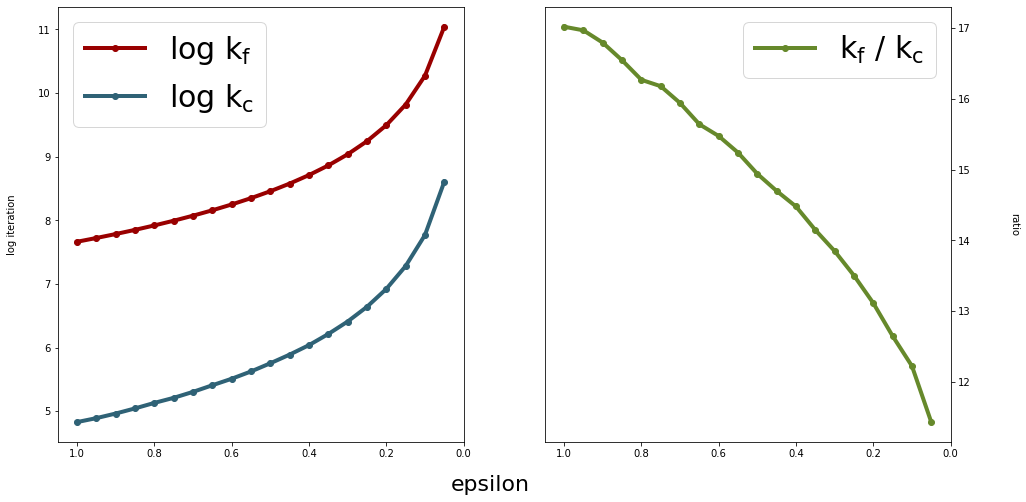

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharex=True)

plt.rcParams.update({'font.size': 22})

axs[0].plot(epsilon_list, [np.log(tmp) for tmp in k_list_formula], color="#990000", marker="o", markersize=6, linewidth=4, label=r"$\log$ $\mathrm{k}_\mathrm{f}$")
axs[0].plot(epsilon_list, [np.log(tmp) for tmp in k_list_empirical_true], color="#2F6276", marker="o", markersize=6, linewidth=4, label=r"$\log$ $\mathrm{k}_\mathrm{c}$")
axs[0].set_xlim(1.05, 0)
axs[0].yaxis.set_label_coords(-0.1, 0.5)
axs[0].set_ylabel(r"log iteration")
axs[0].legend(prop={'size': 30})

# ratio_k_first_true = [k_list_empirical_first[i] / k_list_empirical_true[i] for i in range(num_eps)]
ratio_k_true_formula = [k_list_formula[i] / k_list_empirical_true[i] for i in range(num_eps)]


axs[1].plot(epsilon_list, ratio_k_true_formula, color="#66892B", marker="o", markersize=6, linewidth=4, label=r"$\mathrm{k}_\mathrm{f}$ / $\mathrm{k}_\mathrm{c}$")
axs[1].set_xlim(1.05, 0)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.set_label_coords(1.17, 0.5)
axs[1].set_ylabel("ratio", rotation="-90")
axs[1].legend(prop={'size': 30})

fig.text(0.5, 0.04, 'epsilon', ha='center')

plt.savefig('k_comparison.eps', bbox_inches='tight')
plt.show()

## $\Delta_k / \Delta_{k + 1}$

In [0]:
np.random.seed(999)

# Hyperparameters
dim_a = 10
dim_b = 10
tau = 5
eta = 0.5
k = 200

n = dim_a

alpha = 2
beta = 4

# Initialize UOT parameters
C = np.random.uniform(low=1, high=50, size=(dim_a, dim_b)).astype(float_type)
C = (C + C.T) / 2
a = np.random.uniform(low=0.1, high=1, size=(dim_a, 1)).astype(float_type)
b = np.random.uniform(low=0.1, high=1, size=(dim_b, 1)).astype(float_type)

# Rescaling
a = a / a.sum() * alpha
b = b / b.sum() * beta

In [0]:
g_dual_optimal, u_optimal, v_optimal = solve_g_dual_cp(C=C, a=a, b=b, eta=eta, tau=tau)
output = sinkhorn_uot(C=C, a=a, b=b, eta=eta, tau1=tau, tau2=tau, k=k)

In [0]:
k_fixed = k + 1

delta_u = [max_norm(u - u_optimal) for u in output["u"]]
delta_v = [max_norm(v - v_optimal) for v in output["v"]]

odd_ids = [i for i in range(k_fixed) if i % 2 == 1]
even_ids = [i for i in range(k_fixed) if i % 2 == 0]

even_ids_1 = [i for i in even_ids if i < k_fixed - 1]
ratio_k_even_uv_list = [delta_v[i] / delta_u[i + 1] for i in even_ids_1]

even_ids_2 = [i for i in even_ids if i > 0]
ratio_k_even_vu_list = [delta_u[i - 1] / delta_v[i]  for i in even_ids_2]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


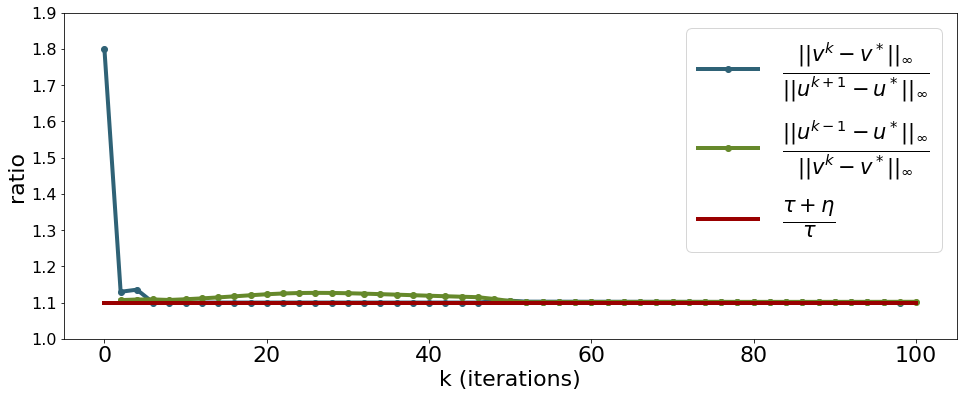

In [0]:
plt.figure(figsize=(16, 6))
plt.rcParams.update({'font.size': 22})

plt.plot(even_ids_1[:50], ratio_k_even_uv_list[:50], color="#2F6276", marker="o", markersize=6, linewidth=4, label=r"$\frac{|| v^{k} - v^* ||_\infty}{|| u^{k + 1} - u^* ||_\infty}$")
plt.plot(even_ids_2[:50], ratio_k_even_vu_list[:50], color="#66892B", marker="o", markersize=6, linewidth=4, label=r"$\frac{|| u^{k - 1} - u^* ||_\infty}{|| v^{k} - v^* ||_\infty}$")
plt.plot([0, 100], [((tau + eta) / tau), ((tau + eta) / tau)], "#990000", linewidth=4, label=r"$\frac{\tau + \eta}{\tau}$")
# plt.ylim(bottom=1.0)
plt.xlabel(r"k (iterations)")
plt.ylabel(r"ratio")
plt.yticks(np.arange(1.0, 2.0, 0.1), ["1.0", "1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1.7", "1.8", "1.9", "2.0"])
plt.tick_params(axis="y", labelsize=16)
plt.legend(prop={'size': 30})

fig.text(0.5, 0.04, 'epsilon', ha='center')

plt.savefig('uv_ratio.eps', bbox_inches='tight')
plt.show()

# Experiment (MNIST)

In [0]:
import numpy as np
import matplotlib.pyplot as plt 
from copy import copy
import random
import pdb
import os 
import gzip
import pickle as pkl
from urllib import request
import torch
from time import time
import cvxpy as cp

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [0]:
def _download_mnist(root_dir):
    data_loc = os.path.join(root_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_loc):
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        print("Downloading data from:", url)
        data_loc = os.path.join(root_dir, 'mnist.pkl.gz')
        data_loc, _ = request.urlretrieve(url, data_loc)
    else: print('WARNING: data might already exist')
    return data_loc

def _load_mnist(root_dir,  split_type, download):
    if download:
        data_loc = _download_mnist(root_dir)
    else:
        data_loc = os.path.join(root_dir, 'mnist.pkl.gz')
    f = gzip.open(data_loc, 'rb')

    train, valid, test = pkl.load(f, encoding='bytes')
    f.close()
    if split_type == 'train':
        x, y = train[0], train[1]
    if split_type == 'valid':
        x, y = valid[0], valid[1]
    if split_type == 'test':
        x, y = test[0], test[1]
    return x, y

In [0]:
def get_entropy(P):
    logP = torch.log(P + 1e-20)
    return -1 * torch.sum(logP * P - P)

def get_KL(P, Q):
    log_ratio = torch.log(P + 1e-20) - torch.log(Q + 1e-20)
    return torch.sum(P * log_ratio - P + Q)

def dotp(x, y):
    return torch.sum(x * y)

def norm1(X):
    return torch.sum(torch.abs(X))

def supnorm(X):
    return torch.max(torch.abs(X))


# main funcs
def get_B(C, u, v, eta):
    n, m = C.shape
    K = - C + u + v.T
    return torch.exp(K / eta)


def f_dual(B, u, v, r, c, eta, t1, t2):
    """
    the dual of the entropic-regularized unbalanced OT
    """
    f = eta * torch.sum(B) + t1 * dotp(torch.exp(- u / t1), r) + t2 * dotp(torch.exp(- v / t2), c)

    return f


def unreg_f(B, C, r, c, eta, t1, t2):
    """
    the unregularized objective with solutions u, v
    """
    a = B.sum(dim=1).reshape(-1, 1)
    b = B.sum(dim=0).reshape(-1, 1)
    return dotp(C, B) + t1 * get_KL(a, r) + t2 * get_KL(b, c)


def f_primal(unreg_f_val, B, eta):
    ent = get_entropy(B) 
    return unreg_f_val - eta * ent



def sinkhorn_uot(C, r, c, eta=1.0, t1=1.0, t2=1.0, n_iter=100, eps=None, opt_val=None, vbo=False):
    """
    :arg C: cost matrix
    :arg r: first marginal
    :arg c: second marginal
    :arg eta: entropic-regularizer
    :arg t1: first KL regularizer
    :arg t2: second Kl regularizer
    :n_iter: number of Sinkhorn iterations
    """

    # convert numpy variables to torch
    C = torch.from_numpy(C)
    r = torch.from_numpy(r)
    c = torch.from_numpy(c)

    # collect some stats
    f_val_list = []
    unreg_f_val_list = []
    f_primal_val_list = []
    sum_B_list = []

    # initial solution
    u = torch.zeros(r.shape, dtype=torch.float64)
    v = torch.zeros(c.shape, dtype=torch.float64)

    # compute before any updates
    B = get_B(C, u, v, eta)
    f_val = f_dual(B, u, v, r, c, eta, t1, t2)
    f_val_list.append(f_val)

    unreg_f_val = unreg_f(B, C, r, c, eta, t1, t2)
    unreg_f_val_list.append(unreg_f_val)

    f_primal_val = f_primal(unreg_f_val, B, eta)
    f_primal_val_list.append(f_primal_val)

    sum_B_list.append(B.sum())


    stop_iter = n_iter
    start = time()
    for i in range(n_iter):
        # update
        if i % 2 == 0:
            a = B.sum(dim=1).reshape(-1, 1)
            u = (u / eta + torch.log(r) - torch.log(a)) * (t1 * eta / (eta + t1))
        else:
            b = B.sum(dim=0).reshape(-1, 1)
            v = (v / eta + torch.log(c) - torch.log(b)) * (t2 * eta / (eta + t2))

	    # compute stats
        B = get_B(C, u, v, eta)

        f_val = f_dual(B, u, v, r, c, eta, t1, t2)
        f_val_list.append(f_val)

        unreg_f_val = unreg_f(B, C, r, c, eta, t1, t2)
        unreg_f_val_list.append(unreg_f_val)

        f_primal_val = f_primal(unreg_f_val, B, eta)
        f_primal_val_list.append(f_primal_val)

        sum_B_list.append(B.sum())


        if eps is not None and unreg_f_val_list[-1] <= opt_val + eps:
            stop_iter = i + 1
            break

        if vbo and (i + 1) % 1000 == 0:
            stop = time()
            print(f'iteration={i+1}, elapsed={stop-start:.3f}, f_dual={f_val:.3f}, f_primal={f_primal_val:.3f}, f_unreg={unreg_f_val:.3f}')
            start = time()


    info = {}
    info['f_val_list'] = f_val_list
    info['unreg_f_val_list'] = unreg_f_val_list
    info['f_primal_val_list'] = f_primal_val_list
    info['sum_B_list'] = sum_B_list
    info['stop_iter'] = stop_iter

    return u, v, info

def exact_uot(C, a, b, tau, vbo=False):
    nr = len(a)
    nc = len(b)
    X = cp.Variable((nr,nc), nonneg=True)

    row_sums = cp.sum(X, axis=1)
    col_sums = cp.sum(X, axis=0)

    obj = cp.sum(cp.multiply(X, C))

    obj -= tau * cp.sum(cp.entr(row_sums))
    obj -= tau * cp.sum(cp.entr(col_sums))

    obj -= tau * cp.sum(cp.multiply(row_sums, cp.log(a)))
    obj -= tau * cp.sum(cp.multiply(col_sums, cp.log(b)))

    obj -= 2 * tau * cp.sum(X)
    obj += tau * cp.sum(a) + tau * cp.sum(b)

    prob = cp.Problem(cp.Minimize(obj))

    prob.solve(solver='SCS', verbose=vbo)

    # print('UOT optimal value:', prob.value)

    return prob.value

In [7]:
USE_PRESET_PAIRS = True


# USE_PRECOMPUTED_OPTVAL = True

def repeat_newdim(x, n_repeat, newdim):
    x = np.expand_dims(x, axis=newdim)
    x = np.repeat(x, n_repeat, newdim)
    return x


def get_L1_C(dim):
    xv, yv = np.meshgrid(np.arange(dim), np.arange(dim), indexing='ij')
    vv1 = np.concatenate((xv.reshape(-1, 1), yv.reshape(-1, 1)), axis=1)

    vv2 = copy(vv1)
    vv1 = repeat_newdim(vv1, dim ** 2, 1)
    vv2 = repeat_newdim(vv2, dim ** 2, 0)
    # print(vv1.shape, vv2.shape)
    C = vv1 - vv2
    C = np.abs(C).sum(axis=-1)
    return C


def get_eta_k(eps, a, b, tau, nr):
    alpha = np.sum(a)
    beta = np.sum(b)
    # S = (alpha + beta + 1 / np.log(nr)) * (2 * tau + 2)
    S = 0.5 * (alpha + beta) + 0.5 + 0.25 / np.log(nr)
    # T = 4 * ((alpha + beta) * (np.log(alpha + beta) + np.log(nr)) + 1)
    T = 0.5 * (alpha + beta) * (np.log(alpha + beta) - np.log(2) + np.log(nr) - 0.5) + np.log(nr) + 5 / 2

    U = np.max([S + T, 2 * eps, 4 * eps * np.log(nr) / tau, 4 * eps * (alpha + beta) * np.log(nr) / tau])
    eta = eps / U

    # print('S, T, U, eps, eta:', S, T, U, eps, eta)

    def supnorm(X):
        return np.max(np.abs(X))

    R = np.log(a).max() + np.log(b).max() + np.max([np.log(nr), supnorm(C) / eta - np.log(nr)])
    k = (tau * U / eps + 1) * (
            np.log(8) + np.log(eta) + np.log(R) + np.log(tau) + np.log(tau + 1) + 3 * np.log(U) - 3 * np.log(eps))

    return eta, k


C = get_L1_C(28).astype(np.float64)
# print(C)

x, y = _load_mnist('.', split_type='train', download=True)
pairs = ((3, 5), (20562, 12428), (2564, 12380), (48485, 7605), (26428, 42698), (6152, 25061), (13168, 7506), (40816, 39370), (846, 16727), (31169, 7144))

k_list_empirical_first = []
k_list_formula = []
uot_opt_val_list = []
eps_list = np.linspace(5.0, 0.5, 10)
tau = 10

print("COMPUTE OPTIMAL VALUES")
for (id1, id2) in pairs:
    print('pair', id1, id2)
    a = x[id1].astype(np.float64)
    b = x[id2].astype(np.float64)
    a = a.reshape(-1, 1)
    b = b.reshape(-1, 1)
    a[a == 0] = 1e-6
    b[b == 0] = 1e-6

    start = time()
    uot_opt_val = exact_uot(C, a.flatten(), b.flatten(), tau, vbo=True)
    print('time elapsed:', time() - start)
    print('exact val:', uot_opt_val)
    uot_opt_val_list.append(uot_opt_val)

COMPUTE OPTIMAL VALUES
pair 3 5
----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1845536
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 616224, constraints m = 619360
Cones:	linear vars: 614656
	exp vars: 4704, dual exp vars: 0
Setup time: 6.11e+00s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 5.76e+21  5.99e+21  1.00e+00 -3.46e+25 -2.13e+20  2.37e+28  1.44e-01 
   100| 7.48e-04  2.30e-02  8.48e-01 -1.06e+03 -8.71e+01  1.84e-10  3.02e+01 
   200| 3.28e-04  6.71e-03  6.68e-02 -1.48e+03 

In [9]:
print("COMPUTE REGULARIZED VALUES")
for (id1, id2), uot_opt_val in zip(pairs, uot_opt_val_list):
    print('pair', id1, id2)
    a = x[id1].astype(np.float64)
    b = x[id2].astype(np.float64)
    a = a.reshape(-1, 1)
    b = b.reshape(-1, 1)
    a[a == 0] = 1e-6
    b[b == 0] = 1e-6
    k_list_empirical_eps = []
    k_list_formula_eps = []
    for eps in eps_list:
        start = time()
        eta, k = get_eta_k(eps, a, b, tau, 784)
        k_list_empirical_eps.append(k)
        print('eps:', eps, 'eta:', eta, 'k:', k)
        u, v, info = sinkhorn_uot(C, a, b, eta=eta, t1=tau, t2=tau, n_iter=10000000, eps=eps, opt_val=uot_opt_val,
                                  vbo=True)
        print('time elapsed:', time() - start)
        print('approx val:', info['unreg_f_val_list'][-1])
        print(info['stop_iter'])
        k_list_formula_eps.append(info['stop_iter'])
        
    k_list_empirical_first.append(k_list_empirical_eps)
    k_list_formula.append(k_list_empirical_eps)

COMPUTE REGULARIZED VALUES
pair 3 5
eps: 5.0 eta: 0.002054772460377554 k: 142777.12022134647
iteration=1000, elapsed=10.117, f_dual=1542.339, f_primal=457.316, f_unreg=457.796
iteration=2000, elapsed=10.126, f_dual=1525.653, f_primal=356.341, f_unreg=356.837
iteration=3000, elapsed=9.606, f_dual=1517.510, f_primal=339.715, f_unreg=340.218
iteration=4000, elapsed=10.597, f_dual=1512.846, f_primal=330.644, f_unreg=331.153
iteration=5000, elapsed=11.402, f_dual=1509.963, f_primal=327.409, f_unreg=327.912
time elapsed: 53.16999077796936
approx val: tensor(326.8374, dtype=torch.float64)
5115
eps: 4.5 eta: 0.0020547724603775545 k: 142777.12022134644
iteration=1000, elapsed=11.983, f_dual=1542.339, f_primal=457.316, f_unreg=457.796
iteration=2000, elapsed=10.386, f_dual=1525.653, f_primal=356.341, f_unreg=356.837
iteration=3000, elapsed=8.515, f_dual=1517.510, f_primal=339.715, f_unreg=340.218
iteration=4000, elapsed=10.375, f_dual=1512.846, f_primal=330.644, f_unreg=331.153
iteration=5000, e

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[ 8.27946441  8.32696356  8.37817522  8.43362342  8.4884619   8.54004307
  8.69959015  9.06823141  9.58464746 10.4602251 ]
[11.79195532 11.79195532 11.79195532 11.79195532 11.79195532 11.79195532
 11.89648301 12.21306    12.65789705 13.41498175]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


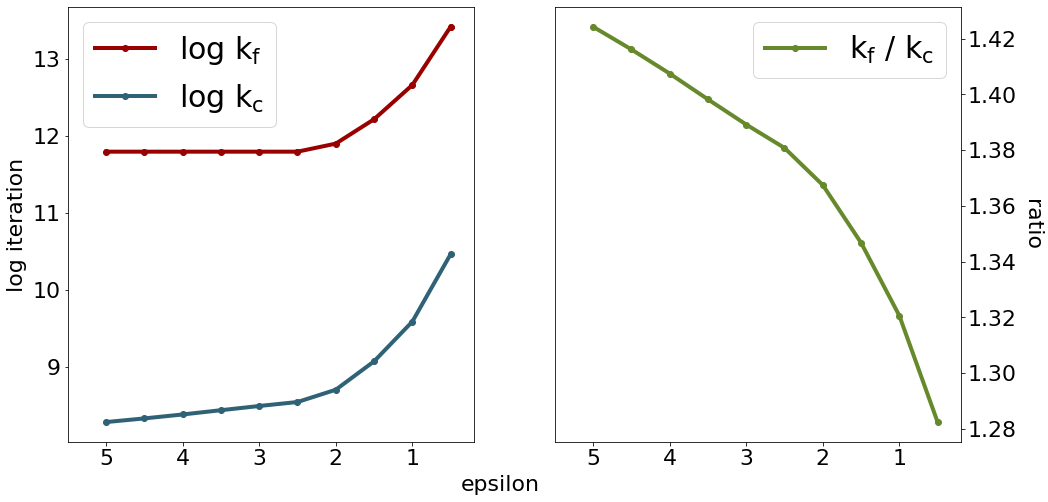

In [14]:
import numpy as np
import matplotlib.pyplot as plt

eps_list = np.linspace(5.0, 0.5, 10)

k_list_empirical_first = np.array(k_list_empirical_first)
k_list_formula = np.array(k_list_formula)

k_list_empirical_first = np.log(k_list_empirical_first)
k_list_empirical_first = np.mean(k_list_empirical_first, axis=0)

k_list_formula = np.log(k_list_formula)
k_list_formula = np.mean(k_list_formula, axis=0)

print(k_list_empirical_first)
print(k_list_formula)

fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
plt.rcParams.update({'font.size': 22})

axs[0].plot(eps_list, [tmp for tmp in k_list_formula], color="#990000", marker="o", markersize=6, linewidth=4, label=r"$\log$ $\mathrm{k}_\mathrm{f}$")
axs[0].plot(eps_list, [tmp for tmp in k_list_empirical_first], color="#2F6276", marker="o", markersize=6, linewidth=4, label=r"$\log$ $\mathrm{k}_\mathrm{c}$")
axs[0].set_xlim(5.5, 0.2)
axs[0].yaxis.set_label_coords(-0.1, 0.5)
axs[0].set_ylabel(r"log iteration")
axs[0].legend(prop={'size': 30})

axs[1].plot(eps_list, [k_list_formula[i] / k_list_empirical_first[i] for i in range(len(k_list_formula))], color="#66892B", marker="o", markersize=6, linewidth=4, label=r"$\mathrm{k}_\mathrm{f}$ / $\mathrm{k}_\mathrm{c}$")
axs[1].set_xlim(5.5, 0.2)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.set_label_coords(1.20, 0.5)
axs[1].set_ylabel("ratio", rotation="-90")
axs[1].legend(prop={'size': 30})

fig.text(0.5, 0.04, 'epsilon', ha='center')

plt.savefig('k_comparison_mnist.eps', bbox_inches='tight')
plt.show()